# Proyecto Final PDS

# Objetivo
- Crear un transmisor y receptor por audio de manera que logre recibir y transmitir una señal usando 8qpsk


# Creacion de señal de informacion

In [110]:
# Codificar mensaje en ascii y devolverlo en binario
def ascii_a_binario(mensaje):
    binario = ''.join(format(ord(char), '08b') for char in mensaje)
    return binario
# Decodificar mensaje en binario y devolverlo en ascii
def binario_a_ascii(binario):
    mensaje = ''.join(chr(int(binario[i:i+8], 2)) for i in range(0, len(binario), 8))
    return mensaje
# Ejemplo de uso

mensaje = "Hola, Mundo!"
binario = ascii_a_binario(mensaje)
print(f"Mensaje original: {mensaje}")
print(f"Mensaje en binario: {binario}")
mensaje_decodificado = binario_a_ascii(binario)
print(f"Mensaje decodificado: {mensaje_decodificado}")

Mensaje original: Hola, Mundo!
Mensaje en binario: 010010000110111101101100011000010010110000100000010011010111010101101110011001000110111100100001
Mensaje decodificado: Hola, Mundo!


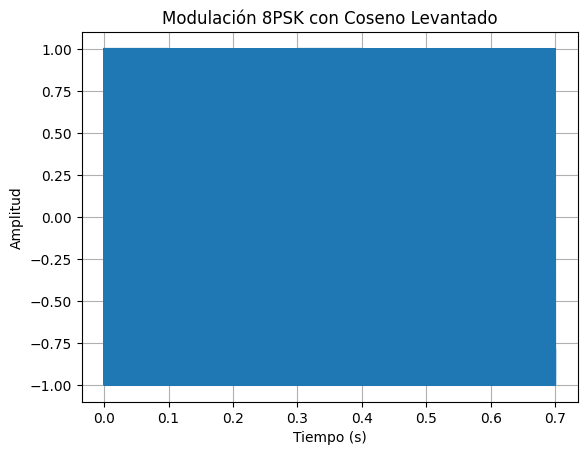

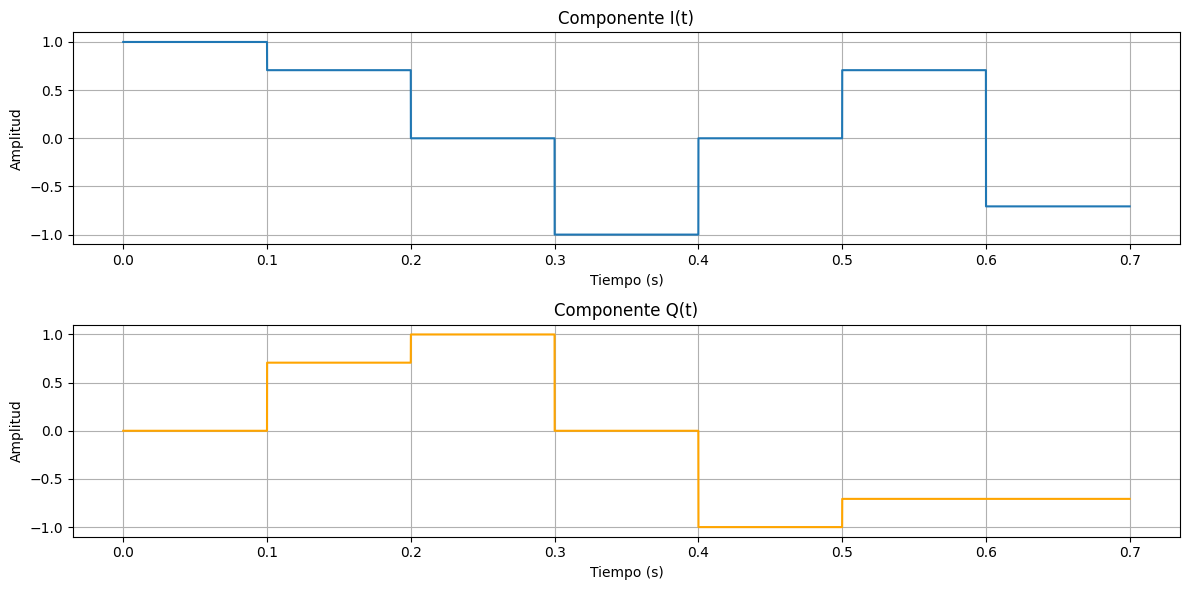

Bits demodulados: 000001011110101100111


In [111]:
# --- Función 8PSK ---
import numpy as np
import matplotlib.pyplot as plt
def raised_cosine_pulse(Tb, fs, beta=0.25):
    N = int(Tb * fs)
    t = np.linspace(-Tb/2, Tb/2, N)

    h = np.zeros(N)
    for i, ti in enumerate(t):
        if ti == 0:
            h[i] = 1.0
        elif abs(1 - (2 * beta * ti/Tb)**2) < 1e-8:
            h[i] = (np.pi/4) * np.sinc(1/(2*beta))
        else:
            h[i] = (np.sin(np.pi * ti / Tb) / (np.pi * ti / Tb)) * \
                   (np.cos(np.pi * beta * ti / Tb) /
                    (1 - (2 * beta * ti / Tb)**2))

    return h, N
def modulate_8psk(bits, Tb, fs, fc, beta=0.25):
    """
    Modula una cadena de bits usando 8PSK + Raised Cosine.

    bits : str       Cadena de bits (múltiplo de 3)
    Tb   : float     Duración de símbolo (NO de bit)
    fs   : float     Frecuencia de muestreo
    fc   : float     Frecuencia de portadora
    beta : float     Roll-off
    """

    # Verificación
    if len(bits) % 3 != 0:
        raise ValueError("La cantidad de bits debe ser múltiplo de 3 para 8PSK.")

    # --- Mapeo Gray 3 bits → ángulo ---
    # 8-PSK de amplitud CONSTANTE = 1
    mapping = {
        "000": 0,
        "001": np.pi/4,
        "011": np.pi/2,
        "010": 3*np.pi/4,
        "110": np.pi,
        "111": 5*np.pi/4,
        "101": 3*np.pi/2,
        "100": 7*np.pi/4,
    }

    symbols = [bits[i:i+3] for i in range(0, len(bits), 3)]
    phases = np.array([mapping[s] for s in symbols])

    # --- Pulso Raised Cosine ---
    h, N = raised_cosine_pulse(Tb, fs, beta)
    # Pulso cuadrada
    h, N = np.ones(N), N
    total_samples = len(symbols) * N
    t = np.linspace(0, Tb * len(symbols), total_samples, endpoint=False)

    # Señales I(t) y Q(t) generadas desde fase
    I = np.zeros(total_samples)
    Q = np.zeros(total_samples)

    for k, phi in enumerate(phases):
        I0 = np.cos(phi)
        Q0 = np.sin(phi)

        start = k * N
        end = start + N

        I[start:end] += I0 * h
        Q[start:end] += Q0 * h

    # --- Modulación pasabanda ---
    carrier_cos = np.cos(2 * np.pi * fc * t)
    carrier_sin = np.sin(2 * np.pi * fc * t)

    # Señal 8PSK pasabanda
    s = I * carrier_cos - Q * carrier_sin

    return t, s, I, Q
bits = "000001011110101100111"   # múltiplo de 3
Tb = 0.1
fs = 100000
fc = 2000
beta = 0.25

t, s, I, Q = modulate_8psk(bits, Tb, fs, fc, beta)

plt.plot(t, s)
plt.title("Modulación 8PSK con Coseno Levantado")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud")
plt.grid()
plt.show()
# Mostrar cambios de fase en I y Q
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(t, I, label='I(t)')
plt.title("Componente I(t)")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud")
plt.grid()
plt.subplot(2, 1, 2)
plt.plot(t, Q, label='Q(t)', color='orange')
plt.title("Componente Q(t)")    
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud")
plt.grid()
plt.tight_layout()
plt.show()
# Decodificación 8PSK
import numpy as np
import math

# --- Pulso Raised Cosine básico ---
def raised_cosine_pulse(Tb, fs, beta=0.25):
    N = int(Tb * fs)
    t = np.linspace(-Tb/2, Tb/2, N)

    h = np.zeros(N)
    for i, ti in enumerate(t):
        if ti == 0:
            h[i] = 1.0
        elif abs(1 - (2 * beta * ti/Tb)**2) < 1e-8:
            h[i] = (np.pi/4) * np.sinc(1/(2*beta))
        else:
            h[i] = (np.sin(np.pi * ti / Tb) / (np.pi * ti / Tb)) * \
                   (np.cos(np.pi * beta * ti / Tb) /
                    (1 - (2 * beta * ti / Tb)**2))

    return h, N


# --- Función 8QAM ---
def modulate_16qam(bits, Tb, fs, fc, beta=0.25):
    """
    Modula una cadena de bits usando 16QAM + Raised Cosine.

    bits : str       Cadena de bits (múltiplo de 4)
    Tb   : float     Duración de símbolo (NO de bit)
    fs   : float     Frecuencia de muestreo
    fc   : float     Frecuencia de portadora
    beta : float     Roll-off
    """

    # Verificación
    if len(bits) % 4 != 0:
        raise ValueError("La cantidad de bits debe ser múltiplo de 4 para 16QAM.")

    # --- Mapeo Gray 4 bits → (I, Q) ---
    mapping = {
        "0000": (-16, -16),
        "0001": (-16, -4),
        "0011": (-16, 4),
        "0010": (-16, 16),
        "0110": (-4, 16),
        "0111": (-4, 4),
        "0101": (-4, -4),
        "0100": (-4, -16),
        "1100": (4, -16),
        "1101": (4, -4),
        "1111": (4, 4),
        "1110": (4, 16),
        "1010": (16, 16),
        "1011": (16, 4),
        "1001": (16, -4),
        "1000": (16, -16),
    }

    symbols = [bits[i:i+4] for i in range(0, len(bits), 4)]
    IQ_pairs = np.array([mapping[s] for s in symbols])

    I_symbols = IQ_pairs[:, 0]
    Q_symbols = IQ_pairs[:, 1]

    # --- Pulso Raised Cosine ---
    h, N = raised_cosine_pulse(Tb, fs, beta)

    total_samples = len(symbols) * N
    t = np.linspace(0, Tb * len(symbols), total_samples, endpoint=False)

    # Señales I(t) y Q(t)
    I = np.zeros(total_samples)
    Q = np.zeros(total_samples)

    for k in range(len(symbols)):
        I0 = I_symbols[k]
        Q0 = Q_symbols[k]

        start = k * N
        end = start + N
        I[start:end] += I0 * h
        Q[start:end] += Q0 * h
    # --- Modulación pasabanda ---
    carrier_cos = np.cos(2 * np.pi * fc * t)
    carrier_sin = np.sin(2 * np.pi * fc * t)    
    # Señal 16QAM pasabanda
    s = I * carrier_cos - Q * carrier_sin
    return t, s, I, Q
def demodulate_16qam(s, Tb, fs, fc, beta=0):
    """
    Demodula una señal 16QAM + Raised Cosine.

    s    : np.array  Señal modulada
    Tb   : float     Duración de símbolo (NO de bit)
    fs   : float     Frecuencia de muestreo
    fc   : float     Frecuencia de portadora
    beta : float     Roll-off
    """

    N = int(Tb * fs)
    total_symbols = len(s) // N

    # --- Pulso Raised Cosine ---
    h, _ = raised_cosine_pulse(Tb, fs, beta)

    # Vectores para I y Q demodulados
    I_demod = np.zeros(total_symbols)
    Q_demod = np.zeros(total_symbols)

    for k in range(total_symbols):
        start = k * N
        end = start + N

        t_segment = np.linspace(k * Tb, (k + 1) * Tb, N, endpoint=False)

        carrier_cos = np.cos(2 * np.pi * fc * t_segment)
        carrier_sin = np.sin(2 * np.pi * fc * t_segment)

        segment = s[start:end]

        I_temp = segment * carrier_cos
        Q_temp = -segment * carrier_sin

        I_demod[k] = (2 / N) * np.sum(I_temp * h)
        Q_demod[k] = (2 / N) * np.sum(Q_temp * h)

    # --- Decodificación de símbolos a bits ---
    bits_out = ""
    for i in range(total_symbols):
        I_val = I_demod[i]
        Q_val = Q_demod[i]

        # Decidir niveles I y Q basados en umbrales
        if I_val < -2:
            I_bits = "00"
        elif -2 <= I_val < 0:
            I_bits = "01"
        elif 0 <= I_val < 2:
            I_bits = "11"
        else:
            I_bits = "10"

        if Q_val < -2:
            Q_bits = "00"
        elif -2 <= Q_val < 0:
            Q_bits = "01"
        elif 0 <= Q_val < 2:
            Q_bits = "11"
        else:
            Q_bits = "10"

        bits_out += I_bits + Q_bits

    return bits_out
def demodulate_8psk(s, Tb, fs, fc, beta=0):
    """
    Demodula una señal 8PSK + Raised Cosine.

    s    : np.array  Señal modulada
    Tb   : float     Duración de símbolo (NO de bit)
    fs   : float     Frecuencia de muestreo
    fc   : float     Frecuencia de portadora
    beta : float     Roll-off
    """

    N = int(Tb * fs)
    total_symbols = len(s) // N

    # --- Pulso Raised Cosine ---
    h, _ = raised_cosine_pulse(Tb, fs, beta)

    # Vectores para I y Q demodulados
    I_demod = np.zeros(total_symbols)
    Q_demod = np.zeros(total_symbols)

    for k in range(total_symbols):
        start = k * N
        end = start + N

        t_segment = np.linspace(k * Tb, (k + 1) * Tb, N, endpoint=False)

        carrier_cos = np.cos(2 * np.pi * fc * t_segment)
        carrier_sin = np.sin(2 * np.pi * fc * t_segment)

        segment = s[start:end]

        I_temp = segment * carrier_cos
        Q_temp = -segment * carrier_sin

        I_demod[k] = (2 / N) * np.sum(I_temp * h)
        Q_demod[k] = (2 / N) * np.sum(Q_temp * h)

    # --- Decodificación de fases a bits ---
    bits_out = ""
    for i in range(total_symbols):
        phi = np.arctan2(Q_demod[i], I_demod[i])
        if phi < 0:
            phi += 2 * np.pi

        if 0 <= phi < np.pi/8 or 15*np.pi/8 <= phi < 2*np.pi:
            bits_out += "000"
        elif np.pi/8 <= phi < 3*np.pi/8:
            bits_out += "001"
        elif 3*np.pi/8 <= phi < 5*np.pi/8:
            bits_out += "011"
        elif 5*np.pi/8 <= phi < 7*np.pi/8:
            bits_out += "010"
        elif 7*np.pi/8 <= phi < 9*np.pi/8:
            bits_out += "110"
        elif 9*np.pi/8 <= phi < 11*np.pi/8:
            bits_out += "111"
        elif 11*np.pi/8 <= phi < 13*np.pi/8:
            bits_out += "101"
        elif 13*np.pi/8 <= phi < 15*np.pi/8:
            bits_out += "100"
    return bits_out
# Ejemplo de uso
demodulated_bits = demodulate_8psk(s, Tb, fs, fc, beta)
print(f"Bits demodulados: {demodulated_bits}")



Bits mandados:010010000110111101101100011000010010110000100000010011010111010101101110011001000110111100100001
Simbología enviada: 24 símbolos


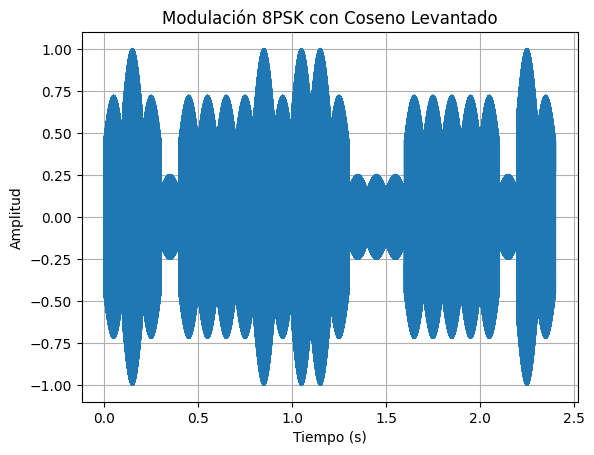

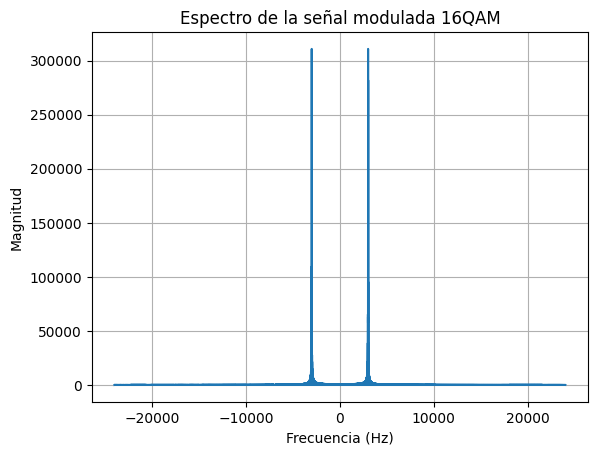

Bits demodulados: 101000101000001000000010100000100000000010000010000000101010001000000010
Duración de la señal: 2.4 segundos


In [189]:
import numpy as np
from scipy.io.wavfile import write

def save_as_wav(filename, signal, fs):
    """
    Guarda una señal en un archivo WAV.

    filename : str      -> Nombre del archivo, ej: "senal_8qam.wav"
    signal   : ndarray  -> Señal normalizada (float32 recomendado)
    fs       : int      -> Frecuencia de muestreo
    """
    # Asegurar normalización correcta
    signal_norm = signal / np.max(np.abs(signal))

    # Convertir a float32 para formato WAV estándar
    audio = (signal_norm).astype(np.float32)

    write(filename, fs, audio)
    print(f"✔ Archivo WAV guardado como: {filename}")

def prepare_audio_signal(signal, fs):
    """
    Prepara una señal para reproducirla con: display(Audio(a, rate=fs)).
    Normaliza amplitud y la deja en tipo float.
    
    signal : ndarray  -> señal modulada
    fs     : int      -> frecuencia de muestreo
    """
    # Normalizar amplitud para evitar clipping
    signal_norm = signal / np.max(np.abs(signal))

    # Convertir a float32 para compatibilidad
    audio = signal_norm.astype(np.float32)

    return audio, fs
from IPython.display import Audio, display
bits =binario 


Tb = 0.1
fs = 48000
fc = 3000

# Modulación 8QAM
t, s, I, Q = modulate_16qam(bits, Tb, fs, fc)

# Preparar señal para escucha
# Agregar seno al inicio para sincronizar con duracion de 3 simbolos

a, fs_a = prepare_audio_signal(s, fs)
display(Audio(a, rate=fs_a))

print(f"Bits mandados:{bits}")
print(f"Simbología enviada: {len(bits)//4} símbolos")

#Grafica de la señal modulada
import matplotlib.pyplot as plt
plt.plot(t, a)
plt.title("Modulación 8PSK con Coseno Levantado")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud")
plt.grid()
plt.show()
# FFt de la señal modulada
S_f = np.fft.fftshift(np.fft.fft(s))
f = np.fft.fftshift(np.fft.fftfreq(len(s), 1/fs))
plt.plot(f, np.abs(S_f))
plt.title("Espectro de la señal modulada 16QAM")
plt.xlabel("Frecuencia (Hz)")

plt.ylabel("Magnitud")
plt.grid()
plt.show()
# Decodificación 8PSK
demodulated_bits = demodulate_16qam(s, Tb, fs, fc)
# Ignorar los bits de sincronización al inicio y final
demodulated_bits = demodulated_bits[12:-12]
print(f"Bits demodulados: {demodulated_bits[:]}")
print(f"Duración de la señal: {len(s)/fs} segundos")

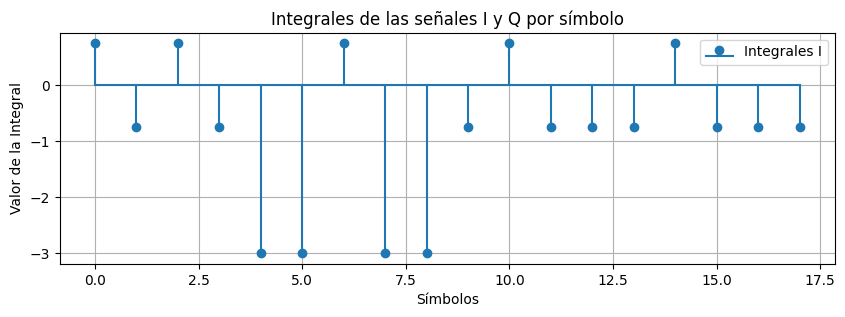

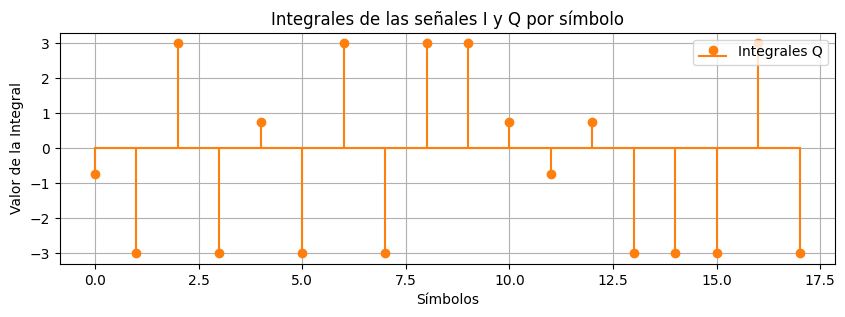

In [ ]:
# Integrar para extrar los símbolos I y Q
Portadora_I = np.cos(2 * np.pi * fc * t)
Portadora_Q = np.sin(2 * np.pi * fc * t )
Pre_Filtro_I = s* Portadora_I  # Simulación de la transmisión
Pre_Filtro_Q = s * Portadora_Q  # Simulación de la transmisión
cantidad_de_simbolo= int(len(t)/(Tb*fs))
duracion_simbolo = int(len(s) / cantidad_de_simbolo)
integral_I = []
for i in range(len(s )//duracion_simbolo):
    start = i * duracion_simbolo
    end = start + duracion_simbolo
    integral = np.trapezoid(Pre_Filtro_I[start:end], dx=1/fs)
    integral_I.append(integral)
integral_Q = []
for i in range(len(s) // duracion_simbolo):
    start = i * duracion_simbolo
    end = start + duracion_simbolo
    integral = np.trapezoid(Pre_Filtro_Q[start:end], dx=1/fs)
    integral_Q.append(integral)
# Normalizar a 1 -1
max_I = max(abs(min(integral_I)), abs(max(integral_I)))
integral_I = [i / max_I*3 for i in integral_I]
max_Q = max(abs(min(integral_Q)), abs(max(integral_Q)))
integral_Q = [i / max_Q*3 for i in integral_Q]
# Graficar las integrales obtenidas
# Ignorar los 3 primeros símbolos (preámbulo) y los 3 últimos (final)
integral_I = integral_I[3:-3]
integral_Q = integral_Q[3:-3]
plt.figure(figsize=(10, 3))
plt.stem(range(len(integral_I)), integral_I, linefmt='C0-', markerfmt='C0o', basefmt='C0-', label='Integrales I')

plt.xlabel('Símbolos')
plt.ylabel('Valor de la Integral')
plt.title('Integrales de las señales I y Q por símbolo')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 3))
plt.stem(range(len(integral_Q)), integral_Q, linefmt='C1-', markerfmt='C1o', basefmt='C1-', label='Integrales Q')
plt.xlabel('Símbolos')
plt.ylabel('Valor de la Integral')
plt.title('Integrales de las señales I y Q por símbolo')
plt.legend()
plt.grid(True)
plt.show()